# Testing FCHL for Delta Learning from XTB
This notebook ensures our automated modeling fitting works

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from moldesign.score.fchl import FCHLKernel, FCHLRepresentation
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from scipy.stats import linregress
from time import perf_counter
from io import StringIO
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

Configuration

In [2]:
max_atoms = 75
target = 'ip.vacuum.small_basis'
low_res = 'ip.vacuum.xtb-no_zpe'
geom_column = 'geometry.neutral.xtb'

## Load the Data
We want the canonical splits created for this problem

In [3]:
train_data = pd.concat([
    pd.read_csv('../datasets/train.csv'),
    pd.read_csv('../datasets/valid.csv')
])
print(f'Loaded {len(train_data)} training entries')

Loaded 2306 training entries


In [4]:
test_data = pd.read_csv('../datasets/test.csv')
print(f'Loaded {len(test_data)} test entries')

Loaded 257 test entries


## Process the data
Need the the FCHL representations and the $\Delta$ parameter to be learned 

In [5]:
rep = FCHLRepresentation(max_size=max_atoms, n_jobs=8)

In [6]:
for data in [train_data, test_data]:
    data['delta'] = data[target] - data[low_res]
    data['rep'] = rep.transform(data[geom_column]).tolist()

## Make a Model Fitting Pipeline 
Something that should work regardless of the amount of training data

In [7]:
model = Pipeline([
    ('kernel', FCHLKernel()),
    ('krr', GridSearchCV(
        estimator=KernelRidge(kernel='precomputed'), # Set the estimator to be KRR
        param_grid={'alpha': np.logspace(-8, 0, 32)},  # Lambda is known as alpha in sklearn
        cv=ShuffleSplit(test_size=0.1, random_state=1),  # Use 10, 90/10% splits
        scoring='neg_mean_absolute_error',  # Score based on MAE
    ))
])

Fit on the whole dataset

In [8]:
model.fit(train_data['rep'].tolist(), train_data['delta'])

Pipeline(steps=[('kernel', FCHLKernel()),
                ('krr',
                 GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=1, test_size=0.1, train_size=None),
                              estimator=KernelRidge(kernel='precomputed'),
                              param_grid={'alpha': array([1.00000000e-08, 1.81160919e-08, 3.28192787e-08, 5.94557071e-08,
       1.07710506e-07, 1.95129342e-07, 3.53498111e-07, 6.40400427e-07,
       1.16015530e-06, 2.10174801...78538e-06,
       1.24960914e-05, 2.26380341e-05, 4.10112707e-05, 7.42963951e-05,
       1.34596032e-04, 2.43835410e-04, 4.41734470e-04, 8.00250228e-04,
       1.44974067e-03, 2.62636353e-03, 4.75794431e-03, 8.61953566e-03,
       1.56152301e-02, 2.82886943e-02, 5.12480588e-02, 9.28414545e-02,
       1.68192432e-01, 3.04698957e-01, 5.51995432e-01, 1.00000000e+00])},
                              scoring='neg_mean_absolute_error'))])

Plot the performance

In [9]:
test_data['delta_pred'] = model.predict(test_data['rep'].tolist())

Text(0, 0.5, '$\\Delta$, ML (V)')

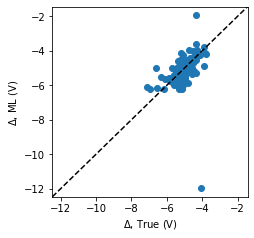

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['delta'], data['delta_pred'])

# Make the y=x
min_ = min(ax.get_xlim() + ax.get_ylim())
max_ = max(ax.get_xlim() + ax.get_ylim())
ax.set_xlim([min_, max_])
ax.set_ylim([min_, max_])
ax.plot(ax.set_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('$\Delta$, True (V)')
ax.set_ylabel('$\Delta$, ML (V)')

Print out the outliers

In [11]:
test_data['error'] = (test_data['delta'] - test_data['delta_pred']).abs()

In [12]:
test_data.sort_values('error', ascending=False)[['identifier.smiles', 'ip.vacuum.xtb-no_zpe', 'ip.vacuum.small_basis', 'error']].head(5)

,identifier.smiles,ip.vacuum.xtb-no_zpe,ip.vacuum.small_basis,error
125,C[Si](C)(C)C1=CC(=O)C=CC1=O,12.781285,8.714530,7.911145
208,C1#CCCC#CCCC#CCC1,12.519490,8.148533,2.440732
159,[H]/N=C(/C)N(C)C=O,13.831881,7.212559,1.637541
8,c1ccc2snnc2c1,13.532832,8.322848,1.105517
180,Cc1c(C)c(C)c(C)c(C)c1C,12.192440,7.373312,1.076238


## Make a Learning Curve
Ensure that the model is getting better as we add more data

In [13]:
train_sizes = np.logspace(1, np.log10(len(train_data)), 6, dtype=np.int)

In [14]:
# Loop over the test sizes
results = []
for ts in tqdm(train_sizes):
    # Split off some training data
    train_subset = train_data.sample(ts, random_state=1)
    
    # Fit the model
    train_time = perf_counter()
    model.fit(train_subset['rep'].tolist(), train_subset['delta'])
    train_time = perf_counter() - train_time
    
    # Evaluate the model on the test set
    test_time = perf_counter()
    test_data['delta_pred'] = model.predict(test_data['rep'].tolist())
    test_time = perf_counter() - test_time
    
    # Store performance information
    results.append({
        'train_size': ts,
        'train_time': train_time,
        'test_time': test_time,
        'alpha': model[1].best_params_['alpha'],
        'mae': mean_absolute_error(test_data['delta'], test_data['delta_pred']),
        'median_abs_error': median_absolute_error(test_data['delta'], test_data['delta_pred'])
    })

100%|██████████| 6/6 [14:14<00:00, 142.34s/it]


In [15]:
results = pd.DataFrame(results)

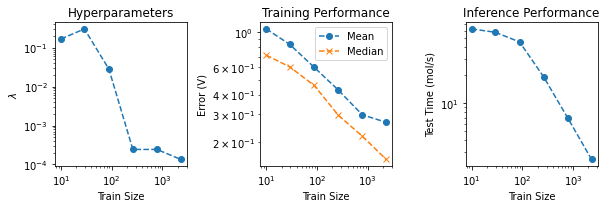

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(8.5, 3.))

ax = axs[0]
ax.loglog(results['train_size'], results['alpha'], '--o')
ax.set_ylabel('$\lambda$')
ax.set_title('Hyperparameters')

ax = axs[1]
ax.loglog(results['train_size'], results['mae'], '--o', label='Mean')
ax.loglog(results['train_size'], results['median_abs_error'], '--x', label='Median')
ax.set_ylabel('Error (V)')
ax.set_title('Training Performance')
ax.legend()

ax = axs[2]
ax.loglog(results['train_size'], len(test_data) / results['test_time'], '--o')
ax.set_ylabel('Test Time (mol/s)')
ax.set_title('Inference Performance')

for ax in axs:
    ax.set_xlabel('Train Size')

fig.tight_layout()